# Evaluating the degree of overlap between the pathway databases and heme graph

This note evaluates the degree of overlap betwen the KEGG, Reactome and WikiPathways across the heme_knowledge model and visualize the overlaps.

In [1]:
import os
import sys
import time
import pybel
import logging
import pybel_tools

from itertools import chain

from pybel_jupyter import to_jupyter # Visualize network
from pybel.struct.mutation import collapse_all_variants, collapse_to_genes
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn2_unweighted, venn3_unweighted

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager

from networkx.algorithms import shortest_path, all_simple_paths # From a(MESH:Heme) to path(MESH:Thrombosis)
import networkx as nx

from pybel.constants import ANNOTATIONS, RELATION
from collections import Counter, defaultdict

import heme_knowledge

In [2]:
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [3]:
time.asctime()

'Thu Jun 27 14:14:40 2019'

In [4]:
pybel.get_version()

'0.13.2'

In [5]:
logging.basicConfig(level=20)

In [6]:
merged_network = heme_knowledge.get_graph()

In [7]:
collapse_to_genes(merged_network) #collapsing all proteins to genes for the sake of simplification and to map it on to the pathway graph

In [8]:
universe = pybel.from_pickle("C:/Users/syedf/Downloads/pathme_universe_bel_graph.bel.pickle")

In [9]:
common_nodes = list(set(merged_network.nodes()).intersection(set(universe.nodes()))) #see which nodes are common

#### Get the pathways database edge data for the nodes in heme_network 

In [10]:
kegg_manager = KeggManager()
reactome_manager = ReactomeManager()
wp_manager = WikipathwaysManager()

In [11]:
def get_pathway_ids_from_node(graph, node):
    """Get the pathways that the node participates in.
    
    :graph: Graph containing pathway annotations that you want
    :node: node to look up coming from heme
    """
    if node not in graph:
        return None
    
    pathways = set()
        
    # Iterate through all the edges and check if the
    for source, target, data in graph.edges(data=True):
        if source == node or target == node:
        
            if ANNOTATIONS not in data:
                continue
            
            pathways_in_edge = data[ANNOTATIONS]["PathwayID"]

            for pathway in pathways_in_edge:
                pathways.add(pathway.strip("_unflatten"))
    return pathways


def get_pathway_names(pathway_ids):
    """Get the pathways that the node participates in."""
    
    kegg_manager = KeggManager()
    reactome_manager = ReactomeManager()
    wp_manager = WikipathwaysManager()
    
    pathway_names = list()
    
    for pathway in pathway_ids:
        
        if pathway.startswith("R-HSA"):
            
            pathway_object = reactome_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
                
            pathway_names.append(pathway_object.name)
            
        elif pathway.startswith("WP"):
            pathway_object = wp_manager.get_pathway_by_id(pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue
            
            pathway_names.append(pathway_object.name)  #append the name for the id

        
        elif pathway.startswith("hsa"):
            pathway_object = kegg_manager.get_pathway_by_id("path:"+pathway)
            
            if not pathway_object:
                print(f"{pathway} not found")
                continue

            pathway_names.append(pathway_object.name)

        else:
            print(f"{pathway} not found")
            
    return pathway_names


def get_pathways_from_nodes(graph, nodes):
    """This funtion makes a dictionary of node: pathway_names"""
  
    id_dic = {}
    
    for node in nodes:
        id_dic[node] = get_pathway_ids_from_node(graph, node)
        
    return id_dic


Mapping_pathways gives the dictionary of nodes common between pathways and heme assembly model:set of pathwayIDs in which these nodes are involved

In [12]:
mapping_pathways = get_pathways_from_nodes(universe, common_nodes)

In [13]:
mapping_pathways

{<BEL g(HGNC:TNF)>: {'R-HSA-75893',
  'WP15',
  'WP1533',
  'WP1584',
  'WP176',
  'WP2431',
  'WP2447',
  'WP2513',
  'WP2586',
  'WP2795',
  'WP2813',
  'WP2864',
  'WP2873',
  'WP2882',
  'WP3624',
  'WP382',
  'WP3941',
  'WP4008',
  'WP4298',
  'WP4329',
  'WP4341',
  'WP4396',
  'WP560',
  'WP727',
  'hsa04060',
  'hsa04217',
  'hsa04350',
  'hsa04612',
  'hsa04620',
  'hsa04621',
  'hsa04625',
  'hsa04650',
  'hsa04660',
  'hsa04930',
  'hsa04932',
  'hsa05014',
  'hsa05134',
  'hsa05143',
  'hsa05145',
  'hsa05152',
  'hsa05160',
  'hsa05161',
  'hsa05164',
  'hsa05170',
  'hsa05205'},
 <BEL g(HGNC:CD86)>: {'R-HSA-389356',
  'hsa04514',
  'hsa04620',
  'hsa04672',
  'hsa05323'},
 <BEL a(CHEBI:"leukotriene B4")>: {'R-HSA-2142691',
  'R-HSA-391906',
  'hsa00590',
  'hsa01100',
  'hsa03320',
  'hsa04080',
  'hsa04750'},
 <BEL g(HGNC:NR1H2)>: {'R-HSA-4090294', 'WP1982', 'hsa04931'},
 <BEL g(HGNC:GSR)>: {'hsa00480'},
 <BEL g(HGNC:PRTN3)>: {'R-HSA-140875', 'R-HSA-449836'},
 <BEL g(HG

#### Prioratizing the pathways 
This function gives the count for each interacting pathway. The pathway with the highest count will be selected for further analysis.

In [14]:
def count_pathways_in_network(dictionary, filter=10):
    """This function gives the count for the pathways common in the merged pathway network and heme model"""
    
    d = defaultdict(int)
    
    for node, pathways in dictionary.items():
        for pathway in pathways:
            d[pathway] += 1
    
    #Select those keys that have occurances more than 5 times
    return {
        pathway: count
        for pathway, count in d.items()
        if count > filter
    }
       
pathway_count_merged = count_pathways_in_network(mapping_pathways)

In [15]:
pathway_count_merged

{'hsa05164': 13,
 'hsa05152': 13,
 'hsa04620': 14,
 'hsa05134': 13,
 'hsa04625': 12,
 'hsa04621': 19,
 'hsa04217': 12,
 'hsa01100': 14,
 'WP2806': 11,
 'hsa05200': 12,
 'hsa04066': 14,
 'hsa04610': 14,
 'hsa05418': 12,
 'hsa04064': 11}

Convert the dictionary of pathways to list having scorings for prioritizing the pathways in path 

In [16]:
pathway_count_merged_list = []
for key, value in pathway_count_merged.items():
    pathway_count_merged_list.append(key)

Paths in network for Thrombosis, Hemolysis and Inflammation

In [63]:
def bel_to_simple_directed(graph):
    """BELGraph to directed NetworkX graph reducing redundant edges."""
    directed_graph = nx.DiGraph()
    
    for sub, obj in graph.edges():
        directed_graph.add_edge(sub, obj)

    return directed_graph
    
    
def pathways_in_paths(graph, s_node, t_node, cutoff=7):
    """This function gives the dictionary of nodes and pathways in path"""
    
    all_paths_flattened = []
    
    pathway_all_path = {}
    
    for node in graph:
        if 'name' in node and node.name == s_node:
            source_node = node
        
        elif 'name' in node and node.name == t_node:
            target_node = node

    if not source_node or not target_node:
        raise ValueError('One of the nodes was not found')
                
    paths = nx.all_simple_paths(graph, source_node, target_node, cutoff = cutoff)
    
    paths = list(paths)
    
    #Gives all the nodes present in the path
    all_nodes_in_paths = set(chain.from_iterable(paths))
        
    print(f"Number of simple paths for {source_node.name}-{target_node.name}: {len(paths)}")
    
    #Get dictionary of node:pathways for the nodes in the path
    for key, value in mapping_pathways.items():
        for node in all_nodes_in_paths:
            if node == key:
                pathway_all_path[key] = value
    
    
    return pathway_all_path, all_nodes_in_paths


merged_network_directed = bel_to_simple_directed(merged_network)

thrombosis_nodes_with_pathways, thrombosis_all_nodes = pathways_in_paths(merged_network_directed, 'heme', 'Thrombosis')  
inflammation_nodes_with_pathways, inflammation_all_nodes  = pathways_in_paths(merged_network_directed, 'heme', 'Inflammation')
hemolysis_nodes_with_pathways, hemolysis_all_nodes  = pathways_in_paths(merged_network_directed, 'heme', 'Hemolysis')    

Number of simple paths for heme-Thrombosis: 677283
Number of simple paths for heme-Inflammation: 661260
Number of simple paths for heme-Hemolysis: 634814


In [67]:
len(thrombosis_all_nodes)

294

In [68]:
len(inflammation_all_nodes)

298

In [69]:
len(hemolysis_all_nodes)

297

Load the paths to pickle

In [21]:
import pickle

In [22]:
pickle_out = open('thrombosis_nodes_with_pathways.pickle','wb')
pickle.dump(thrombosis_nodes_with_pathways, pickle_out)
pickle_out.close()

In [23]:
pickle_out = open('inflammation_nodes_with_pathways.pickle','wb')
pickle.dump(inflammation_nodes_with_pathways, pickle_out)
pickle_out.close()

In [24]:
pickle_out = open('hemolysis_nodes_with_pathways.pickle','wb')
pickle.dump(hemolysis_nodes_with_pathways, pickle_out)
pickle_out.close()

Read the pickle files

In [25]:
thrombosis_dict = pickle.load(open('thrombosis_nodes_with_pathways.pickle', 'rb'))

In [26]:
inflammation_dict = pickle.load(open('inflammation_nodes_with_pathways.pickle','rb'))

In [27]:
hemolysis_dict = pickle.load(open('hemolysis_nodes_with_pathways.pickle', 'rb'))

#### Venn Diagram

Visualizing equivalent pathways between thrombosis, hemolysis and inflammation.

In [44]:
# def count_pathways_in_network(dictionary, filter=0):
#     """This function gives the count for the pathways common in the merged pathway network and heme model"""
    
#     d = defaultdict(int)
    
#     for node, pathways in dictionary.items():
#         for pathway in pathways:
#             d[pathway] += 1
    
#     #Select those keys that have occurances more than 5 times
#     return {
#         pathway: count
#         for pathway, count in d.items()
#         if count > filter
#     }
       
# pathway_count_thrombosis = count_pathways_in_network(thrombosis_dict)
# pathway_count_inflammation = count_pathways_in_network(inflammation_dict)
# pathway_count_hemolysis = count_pathways_in_network(hemolysis_dict)

# common_pathways = list(set(pathway_count_inflammation).intersection(set(pathway_count_hemolysis), set(pathway_count_thrombosis))) #see which nodes are common

# thorm_list = pathway_count_thrombosis.keys()
# inflamm_list = pathway_count_inflammation.keys()
# hemolysis_list = pathway_count_hemolysis.keys()

# plt.figure(figsize=(10, 10))
# out = venn3_unweighted([set(thorm_list), set(inflamm_list), set(hemolysis_list)], set_labels = ('Thrombosis', 'Inflammation', 'Hemolysis'))

# for text in out.set_labels:
#     text.set_fontsize(24)
# for text in out.subset_labels:
#     text.set_fontsize(22)
    
# plt.title('Overlaps across pathways between Thrombosis, Inflammation and Hemolysis\n', fontsize=30)
        
# out.get_patch_by_id('001').set_color('#5bc0de') #Thrombosis
# out.get_patch_by_id('001').set_alpha(1.0)
# out.get_patch_by_id('010').set_color('#df3f18') # Inflammation
# out.get_patch_by_id('010').set_alpha(1.0)
# out.get_patch_by_id('011').set_color('#9d807b') # thrombosis - Inflammation
# out.get_patch_by_id('011').set_alpha(1.0)
# out.get_patch_by_id('100').set_color('#5cb85c') # Hemolysis
# out.get_patch_by_id('100').set_alpha(1.0)
# out.get_patch_by_id('110').set_color('#f3ac1f') # Hemolysis - Inflammation
# out.get_patch_by_id('111').set_alpha(1.0)
# out.get_patch_by_id('111').set_color('#ffffff') # Middle
# out.get_patch_by_id('111').set_alpha(1.0)
# out.get_patch_by_id('101').set_color('#a2ded0') # Hemolysis - Thrombosis
# out.get_patch_by_id('101').set_alpha(1.0)

# # plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/pathway_overlap.png', dpi=300, bbox_inches='tight')

# plt.show()


Visualizing common nodes between thrombosis, hemolysis and inflammation.

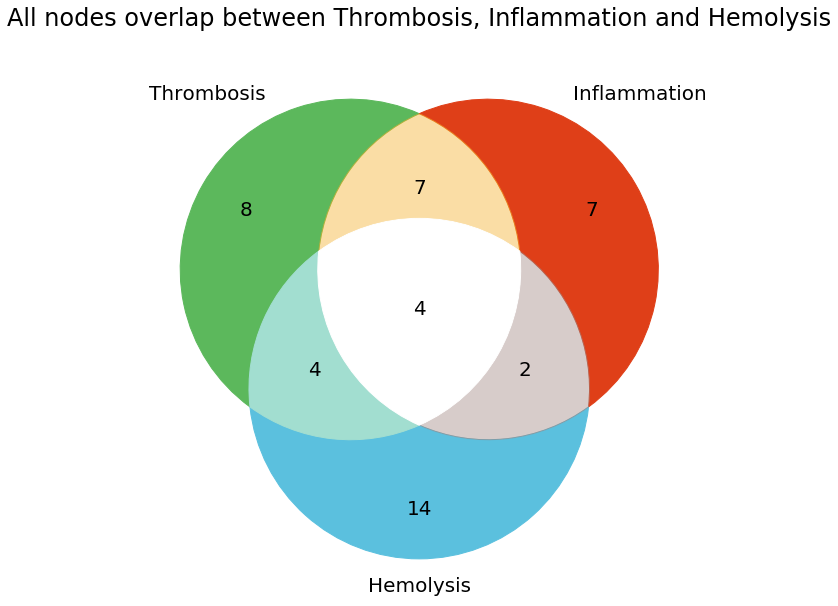

In [29]:
plt.figure(figsize=(10, 10))
out = venn3_unweighted([thrombosis_all_nodes, inflammation_all_nodes, hemolysis_all_nodes], set_labels = ('Thrombosis', 'Inflammation', 'Hemolysis'))

for text in out.set_labels:
    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(20)
    
plt.title('All nodes overlap between Thrombosis, Inflammation and Hemolysis\n', fontsize=24)
        
out.get_patch_by_id('001').set_color('#5bc0de') #Thrombosis
out.get_patch_by_id('001').set_alpha(1.0)
out.get_patch_by_id('010').set_color('#df3f18') # Inflammation
out.get_patch_by_id('010').set_alpha(1.0)
out.get_patch_by_id('011').set_color('#9d807b') # thrombosis - Inflammation
# out.get_patch_by_id('011').set_alpha(1.0)
out.get_patch_by_id('100').set_color('#5cb85c') # Hemolysis
out.get_patch_by_id('100').set_alpha(1.0)
out.get_patch_by_id('110').set_color('#f3ac1f') # Hemolysis - Inflammation
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('111').set_color('#ffffff') # Middle
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('101').set_color('#a2ded0') # Hemolysis - Thrombosis
out.get_patch_by_id('101').set_alpha(1.0)

plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/nodes_overlap.png', dpi=300, bbox_inches='tight')

plt.show()

Intersect between the list having pathway scores and common pathways between thrombosis, heme and inflammation in order to drill down the pathways occuring the most in path of pathways

In [43]:
#intersect_on_basis_of_pathwayscore = list(set(common_pathways).intersection(set(pathway_count_merged_list))) #see which nodes are common

In [31]:
def get_pathways_from_universe(pathway_to_analyse, pathways_in_path, universe):

    # filter nodes for the pathway you are interested in
    nodes_in_pathways_of_interest = defaultdict(list)

    for node, pathways in pathways_in_path.items():
        for pathway in pathways:
            if pathway not in pathway_to_analyse:
                continue
            nodes_in_pathways_of_interest[node].append(pathway)


    # Get a subgraph from pathway_universe
    pathways_to_be_merged = []
    for node, pathways in nodes_in_pathways_of_interest.items():
        for pathway_id in pathways:

            if pathway_id[0:].startswith("hsa"):
                pathway_id = pathway_id + "_unflatten"

            pathway_subgraph = pybel.struct.get_subgraph_by_annotation_value(universe, "PathwayID", pathway_id)
            if not pathway_subgraph.nodes():
                print(f"There are no nodes in {pathway_id}")
                
                continue

            print(f"{pathway_id} has {pathway_subgraph.number_of_nodes()} nodes")
            pathways_to_be_merged.append(pathway_subgraph)

    # Merged all the pathways that we are interested in
    return pybel.struct.union(pathways_to_be_merged)
    
#pathway_to_analyse = ['WP2806', 'hsa05418', 'hsa04610', 'hsa04064', 'hsa04620'] 

pathway_to_analyse = ['hsa05418'] 

pathway_network_merged = get_pathways_from_universe(pathway_to_analyse, thrombosis_nodes_with_pathways, universe)


# Merge all the pathways subgraphs and heme knowledge subgraph
pathways_and_heme_paths = pybel.struct.union([
    pathway_network_merged, 
    merged_network.subgraph(thrombosis_all_nodes)
])

hsa05418_unflatten has 106 nodes


In [32]:
to_jupyter(pathway_network_merged)

<IPython.core.display.Javascript object>

In [33]:
pathways_and_heme_paths.summarize()

None vNone
Number of Nodes: 128
Number of Edges: 379
Number of Citations: 35
Number of Authors: 246
Network Density: 2.33E-02
Number of Components: 4
Number of Warnings: 0


In [34]:
to_jupyter(pathways_and_heme_paths)

<IPython.core.display.Javascript object>

In [35]:
pathway_path_subgraph = pybel.to_pickle(pathways_and_heme_paths, 'pathways_and_heme_paths.pickle')

In [36]:
to_jupyter(merged_network.subgraph(hemolysis_nodes_with_pathways.keys()))

<IPython.core.display.Javascript object>

In [37]:
to_jupyter(merged_network.subgraph(hemolysis_all_nodes))

<IPython.core.display.Javascript object>

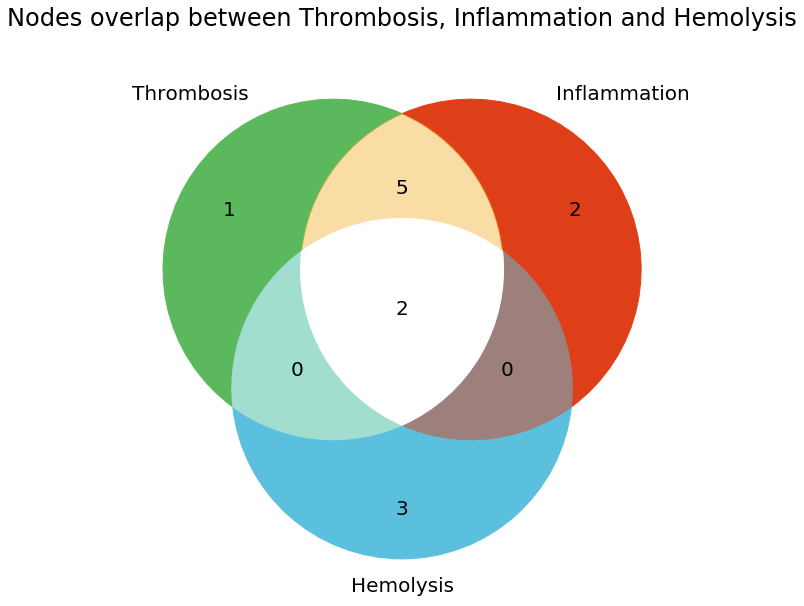

In [38]:
plt.figure(figsize=(10, 10))
out = venn3_unweighted([thrombosis_nodes_with_pathways.keys(), inflammation_nodes_with_pathways.keys(), hemolysis_nodes_with_pathways.keys()], set_labels = ('Thrombosis', 'Inflammation', 'Hemolysis'))

for text in out.set_labels:
    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(20)
    
plt.title('Nodes overlap between Thrombosis, Inflammation and Hemolysis\n', fontsize=24)
        
out.get_patch_by_id('001').set_color('#5bc0de') #Thrombosis
out.get_patch_by_id('001').set_alpha(1.0)
out.get_patch_by_id('010').set_color('#df3f18') # Inflammation
out.get_patch_by_id('010').set_alpha(1.0)
out.get_patch_by_id('011').set_color('#9d807b') # thrombosis - Inflammation
out.get_patch_by_id('011').set_alpha(1.0)
out.get_patch_by_id('100').set_color('#5cb85c') # Hemolysis
out.get_patch_by_id('100').set_alpha(1.0)
out.get_patch_by_id('110').set_color('#f3ac1f') # Hemolysis - Inflammation
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('111').set_color('#ffffff') # Middle
out.get_patch_by_id('111').set_alpha(1.0)
out.get_patch_by_id('101').set_color('#a2ded0') # Hemolysis - Thrombosis
out.get_patch_by_id('101').set_alpha(1.0)

plt.savefig('C:/Users/syedf/OneDrive/Thesis/ThesisLatex_Farah/img/nodes_with_pathways_overlap.png', dpi=300, bbox_inches='tight')

plt.show()

In [39]:
def bel_to_simple_directed(graph):
    """BELGraph to directed NetworkX graph reducing redundant edges."""
    directed_graph = nx.DiGraph()
    
    for sub, obj in graph.edges():
        directed_graph.add_edge(sub, obj)

    return directed_graph

merged_network_directed = bel_to_simple_directed(merged_network)

#gives the paths from heme-thrombosis
for node in merged_network_directed:
        if 'name' in node and node.name == 'heme':
            source_node = node
        
        elif 'name' in node and node.name == 'Inflammation':
            target_node = node
            
        if not source_node or not target_node:
            raise ValueError('One of the nodes was not found')

data = nx.all_simple_paths(merged_network_directed, source_node, target_node, cutoff= 3)

via_key_players_list = []

for path in data:
    for node in path:
        if 'name' in node and node.name == 'TLR4':
            via_key_players_list.append(path)
            

NameError: name 'source_node' is not defined

In [41]:
pybel.struct.summary.get_namespaces(merged_network)

{'CHEBI',
 'GO',
 'HGNC',
 'HM',
 'HP',
 'INTERPRO',
 'MESH',
 'MGI',
 'PFAM',
 'RGD',
 'SCOMP'}

In [42]:
pybel.struct.summary.get_names_by_namespace(merged_network, 'MGI')

{'Acta2',
 'Alb',
 'Bach1',
 'Blvrb',
 'Bmp4',
 'Casp1',
 'Ccl2',
 'Ccl5',
 'Cd163',
 'Cdc42',
 'Col1a1',
 'Cox4i1',
 'Csf1',
 'Cubn',
 'Cxcl1',
 'Diaph3',
 'Dock8',
 'Eif2ak1',
 'Epo',
 'Erfe',
 'F3',
 'Flvcr1',
 'Fth1',
 'Ftl1',
 'Gapdh',
 'Gclc',
 'Got1',
 'Gp6',
 'Gpt',
 'Gsr',
 'Hamp',
 'Havcr1',
 'Hbb-b1',
 'Hif1a',
 'Hmgb1',
 'Hmox1',
 'Hp',
 'Hpx',
 'Hrg',
 'Hspa2',
 'Icam1',
 'Il1b',
 'Il6',
 'Lcn2',
 'Lrp1',
 'Ly76',
 'Mb',
 'Mki67',
 'Mmp12',
 'Mmp13',
 'Mmp9',
 'Nfkb1',
 'Nlrp3',
 'P2rx4',
 'P2rx7',
 'Pln',
 'Prdx1',
 'Prdx2',
 'Prdx3',
 'Prdx4',
 'Prdx5',
 'Prdx6',
 'Pycard',
 'Ryr2',
 'Sele',
 'Serpina1a',
 'Siglec1',
 'Slc11a2',
 'Slc40a1',
 'Slc48a1',
 'Sod1',
 'Spic',
 'Sqstm1',
 'Syp',
 'Tfrc',
 'Tgfb1',
 'Timp2',
 'Tlr4',
 'Tnf',
 'Treml4',
 'Trf',
 'Txn1',
 'Txnrd1',
 'Txnrd2',
 'Txnrd3',
 'Vcam1',
 'Vwf'}